 # Opis notatnika
 Zmierzamy do końca analizy danych, które zostały nam udostępnione. Ten krok dodaje jeszcze więcej informacji do naszego wyjściowego zbioru. Tym razem sprawdzimy między innymi to, czy opóźnienia lotów zależne są od trasy czy warunków pogodowych.

##### Importujemy potrzebne biblioteki oraz plik z ukrytymi danymi do logowania

In [3]:
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar
import plotly.express as px

In [4]:
# Ładujemy zmienne środowiskowe z pliku .env
load_dotenv('DB_pass.env')

True

##### Podłączamy się do bazy danych

In [6]:
# Tworzymy url połączenia
url = f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('N_DB_NAME')}"

# Tworzymy engine dla sqlalchemy
engine = create_engine(url)

##### Przygotowujemy implementację metody `read_sql_table`

In [8]:
def read_sql_table(table_name):
    print(f"Loading data from table {table_name} in chunks...")

    # Wczytujemy tabelę z bazy danych w fragmentach po 100 000 wierszy
    part_df = pd.read_sql_table(
        table_name=table_name,
        con=engine,
        schema=None, # jeśli używamy innego niż domyślny
        index_col=None, # kolumny, które mają być użyte jako indeksy
        coerce_float=True, # jeśli chcemy przekształcić kolumny float na float64
        parse_dates=None, # przekształcenie kolumn na datetime - można zmienić po lepszym zapoznaniu się z danymi
        columns=None, # wybór tylko niektórych kolumn do załadowania
        chunksize=100000 # ilość wierszy na raz - tutaj 100 000 powinno być optymalne
    )

    # Łączymy fragmenty w jeden DF
    df = pd.concat(part_df, ignore_index=True)

    print(f"Data loaded successfully from table {table_name}.")
    return df

##### Wczytujemy zapisaną wcześniej ramkę danych `flight_df` do zmniennej o takiej samej nazwie

In [10]:
# Ścieżka do pliku CSV
file_path = '../data/processed/flight_df_02.csv'

# Wczytujemy dane z pliku CSV do ramki danych
flight_df = pd.read_csv(file_path)

# Sprawdzenie pierwszych kilku wierszy, aby upewnić się, że dane zostały poprawnie wczytane
flight_df.head()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,is_delayed,is_weekend,distance_agg,manufacture_year,manufacture_year_agg
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,NaN,NaN,NaN,NaN,2019,0,1,1100.0,2005,2004
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,NaN,NaN,NaN,NaN,2019,0,1,1100.0,2016,2016
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,0.0,10.0,0.0,3.0,2019,0,1,1100.0,1998,1998
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,NaN,NaN,NaN,NaN,2019,0,1,1100.0,1998,1998
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,NaN,NaN,NaN,NaN,2019,0,1,500.0,2001,2001


 # Wzbogacenie o `airport_list`
 Wczytujemy do obszaru roboczego tabelę `airport_list` używając procedury `read_sql_table`.  
 1. Sprawdzamy, czy klucz `origin_airport_id` jest unikalny, tj. nie ma dwóch takich samych wartości w kolumnie `origin_airport_id`.  
 1. Jeśli duplikaty nie występują, złączamy ramki `airport_list_df` wraz z aktualną `flight_df`, używając kolumny `origin_airport_id` oraz złączenia typu `LEFT JOIN`. Z ramki `airport_list_df` interesuje nas dodanie kolumny `origin_city_name`.  
 1. Dodatkowo dokonujemy jeszcze raz złączenia ramki `flight_df` z `airport_list_df`, tym razem jednak złączając kolumnę `destination_airport_id` wraz z `origin_airport_id`. Podobnie jak wcześniej, interesuje nas kolumna `origin_city_name`, jedank ona powinna zostać wyświetlona jako `destination_city_name`

In [12]:
# Wczytujemy tabelę aircraft używając read_sql_table
airport_list_df = read_sql_table('airport_list')
airport_list_df.head()

Loading data from table airport_list in chunks...
Data loaded successfully from table airport_list.


,id,origin_airport_id,display_airport_name,origin_city_name,name
0,1,11638,Fresno Air Terminal,"Fresno, CA","FRESNO YOSEMITE INTERNATIONAL, CA US"
1,2,13342,General Mitchell Field,"Milwaukee, WI","MILWAUKEE MITCHELL AIRPORT, WI US"
2,3,13244,Memphis International,"Memphis, TN","MEMPHIS INTERNATIONAL AIRPORT, TN US"
3,4,15096,Syracuse Hancock International,"Syracuse, NY","SYRACUSE HANCOCK INTERNATIONAL AIRPORT, NY US"
4,5,10397,Atlanta Municipal,"Atlanta, GA",ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...


##### Sprawdzamy, czy występują duplikaty dla kolumny dla całej ramki danych oraz dla samej kolumny `origin_airport_id`

In [14]:
# Sprawdzamy, czy wystąpiły duplikaty dla całej ramki danych
duplicates = airport_list_df[airport_list_df.duplicated()]

if not duplicates.empty:
    print(duplicates)
else:
    print("Nie ma duplikatów.")

Nie ma duplikatów.


In [15]:
# Sprawdzamy, czy wystąpiły duplikaty w kolumnie 'origin_airport_id'
duplicates = airport_list_df[airport_list_df.duplicated(subset=['origin_airport_id'])]

if not duplicates.empty:
    print(duplicates)
else:
    print("Nie ma duplikatów.")

Nie ma duplikatów.


Dokonujemy złączenia ramki `flight_df` oraz `airport_list_df` używając `origin_airport_id`

In [17]:
# Złączamy ramki airport_list_df z flight_df na podstawie kolumny origin_airport_id
tmp_flight_df = flight_df.merge(airport_list_df[['origin_airport_id', 'origin_city_name']],
                                on='origin_airport_id', 
                                how='left')

In [18]:
tmp_flight_df.head()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,nas_delay,security_delay,late_aircraft_delay,year,is_delayed,is_weekend,distance_agg,manufacture_year,manufacture_year_agg,origin_city_name
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,NaN,NaN,NaN,2019,0,1,1100.0,2005,2004,"Atlanta, GA"
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,NaN,NaN,NaN,2019,0,1,1100.0,2016,2016,"Atlanta, GA"
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,10.0,0.0,3.0,2019,0,1,1100.0,1998,1998,"Atlanta, GA"
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,NaN,NaN,NaN,2019,0,1,1100.0,1998,1998,"Atlanta, GA"
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,NaN,NaN,NaN,2019,0,1,500.0,2001,2001,"Atlanta, GA"


In [19]:
# Tworzymy ramkę tymczasową ze zmienioną nazwą kolumn i doklejamy ją do naszej głównej ramki (jeszcze zapisaną pod zmienną tymczasową)
airport_list_df_renamed = airport_list_df.rename(columns={'origin_city_name': 'destination_city_name', 'origin_airport_id': 'dest_airport_id'})

tmp_flight_df2 = tmp_flight_df.merge(airport_list_df_renamed[['dest_airport_id', 'destination_city_name']],
                                    on='dest_airport_id',
                                    how='left')

In [20]:
tmp_flight_df2.head()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,security_delay,late_aircraft_delay,year,is_delayed,is_weekend,distance_agg,manufacture_year,manufacture_year_agg,origin_city_name,destination_city_name
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,NaN,NaN,2019,0,1,1100.0,2005,2004,"Atlanta, GA","Denver, CO"
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,NaN,NaN,2019,0,1,1100.0,2016,2016,"Atlanta, GA","Denver, CO"
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,0.0,3.0,2019,0,1,1100.0,1998,1998,"Atlanta, GA","Denver, CO"
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,NaN,NaN,2019,0,1,1100.0,1998,1998,"Atlanta, GA","Denver, CO"
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,NaN,NaN,2019,0,1,500.0,2001,2001,"Atlanta, GA","Fort Lauderdale, FL"


In [21]:
flight_df = tmp_flight_df2.copy()

In [22]:
flight_df.head()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,security_delay,late_aircraft_delay,year,is_delayed,is_weekend,distance_agg,manufacture_year,manufacture_year_agg,origin_city_name,destination_city_name
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,NaN,NaN,2019,0,1,1100.0,2005,2004,"Atlanta, GA","Denver, CO"
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,NaN,NaN,2019,0,1,1100.0,2016,2016,"Atlanta, GA","Denver, CO"
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,0.0,3.0,2019,0,1,1100.0,1998,1998,"Atlanta, GA","Denver, CO"
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,NaN,NaN,2019,0,1,1100.0,1998,1998,"Atlanta, GA","Denver, CO"
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,NaN,NaN,2019,0,1,500.0,2001,2001,"Atlanta, GA","Fort Lauderdale, FL"


In [23]:
flight_df.shape

(1045174, 35)

 ## Analiza według lotnisk oraz tras
 Wykonujemy poniższe polecenia:  
 1. Wyznaczamy lotniska, z których **odlatywało** najwięcej samolotów. Wynik zapisujemy do ramki `top_airports_origin_df`.
 1. Wyznaczamy lotnika, na których najwięcej lotów **się kończyło**. Wynik zapisujemy do ramki `top_airports_destination_df`.  
 1. Wyznaczamy najczęściej uczęszczaną trasę, wynik zapisujemy do ramki `top_route_df`.  
 1. Przy założeniu, że reprezentatywna liczba lotów na trasie wynosi ponad 500, wyznaczamy dodatkowo top 10:  
     - tras z **najmniejszym odsetkiem opóźnień**, wynik zapisujemy do ramki `least_route_delays_df`.  
     - tras z **największym odsetkiem opóźnień**, wynik zapisujemy do ramki `top_route_delays_df`.

In [25]:
# Grupujemy dane według origin_airport_id, zliczamy ilości dla każdego lotniska, sortujemy od największego
tmp_top_airports_origin_df = top_airports_origin_df = flight_df.groupby('origin_airport_id').agg(
    total_flights=('origin_airport_id', 'count')
).reset_index().sort_values(by='total_flights', ascending=False)

top_5_origin = tmp_top_airports_origin_df['total_flights'].iloc[4]

top_airports_origin_df = tmp_top_airports_origin_df[tmp_top_airports_origin_df['total_flights'] >= top_5_origin].reset_index(drop=True)
top_airports_origin_df

,origin_airport_id,total_flights
0,10397,119753
1,13930,102805
2,12892,87404
3,11292,64409
4,12953,57684


In [26]:
# Grupujemy dane według destination_airport_id, zliczamy ilości dla każdego lotniska, sortujemy od największego
tmp_top_airports_destination_df = top_airports_destination_df = flight_df.groupby('dest_airport_id').agg(
    total_flights=('dest_airport_id', 'count')
).reset_index().sort_values(by='total_flights', ascending=False)

top_5_destination = tmp_top_airports_destination_df['total_flights'].iloc[4]

top_airports_destination_df = tmp_top_airports_destination_df[tmp_top_airports_destination_df['total_flights'] >= top_5_destination].reset_index(drop=True)
top_airports_destination_df

,dest_airport_id,total_flights
0,10397,119515
1,13930,98589
2,12892,87321
3,11292,64469
4,12953,57668


In [27]:
# Grupujemy dane wg origin_airport_id i dest_airport_id
tmp_top_route_df = flight_df.groupby(['origin_airport_id', 'dest_airport_id']).agg(total_flights=('id', 'count')).reset_index().sort_values(by='total_flights', ascending=False)

top_1_route = tmp_top_route_df['total_flights'].iloc[0]

top_route_df = tmp_top_route_df[tmp_top_route_df['total_flights'] >= top_1_route].reset_index(drop=True)
top_route_df

,origin_airport_id,dest_airport_id,total_flights
0,13930,12953,14214


In [28]:
# Wyznaczamy TOP 10 tras z najmniejszym odsetkiem opóźnień dla połączeń powyżej 500 lotów

tmp_least_route_delays_df  = flight_df.groupby(['origin_airport_id', 'dest_airport_id']).agg(
    total_flights=('is_delayed', 'count'),
    delayed_flights=('is_delayed', 'sum')
).reset_index()

tmp_least_route_delays_df['delay_percentage'] = ((tmp_least_route_delays_df['delayed_flights'] / tmp_least_route_delays_df['total_flights']) * 100).round(2)

tmp_least_route_delays_df = tmp_least_route_delays_df.sort_values(by='delay_percentage', ascending=True)

tmp_least_route_delays_df = tmp_least_route_delays_df[tmp_least_route_delays_df['total_flights'] > 500]

top_10_least_route_delays = tmp_least_route_delays_df['delay_percentage'].iloc[9]

least_route_delays_df = tmp_least_route_delays_df[tmp_least_route_delays_df['delay_percentage'] <= top_10_least_route_delays].reset_index(drop=True)

least_route_delays_df

,origin_airport_id,dest_airport_id,total_flights,delayed_flights,delay_percentage
0,12173,12982,6940,355,5.12
1,12402,12173,5091,266,5.22
2,12173,12402,5097,267,5.24
3,12758,12173,7792,416,5.34
4,12982,12173,6933,375,5.41
5,12173,13830,10725,584,5.45
6,12173,12758,7803,450,5.77
7,13830,12173,10718,688,6.42
8,10299,14747,6966,615,8.83
9,14893,14679,5816,639,10.99


In [29]:
# Wyznaczamy TOP 10 tras z najmniejszym odsetkiem opóźnień dla połączeń powyżej 500 lotów

tmp_top_route_delays_df  = flight_df.groupby(['origin_airport_id', 'dest_airport_id']).agg(
    total_flights=('is_delayed', 'count'),
    delayed_flights=('is_delayed', 'sum')
).reset_index()

tmp_top_route_delays_df['delay_percentage'] = ((tmp_top_route_delays_df['delayed_flights'] / tmp_top_route_delays_df['total_flights']) * 100).round(2)

tmp_top_route_delays_df = tmp_top_route_delays_df.sort_values(by='delay_percentage', ascending=False)

tmp_top_route_delays_df = tmp_top_route_delays_df[tmp_top_route_delays_df['total_flights'] > 500]

top_10_top_route_delays = tmp_top_route_delays_df['delay_percentage'].iloc[9]

top_route_delays_df = tmp_top_route_delays_df[tmp_top_route_delays_df['delay_percentage'] >= top_10_top_route_delays].reset_index(drop=True)

top_route_delays_df

,origin_airport_id,dest_airport_id,total_flights,delayed_flights,delay_percentage
0,13204,11618,6772,2270,33.52
1,11292,14771,5516,1769,32.07
2,10397,11618,6010,1853,30.83
3,11618,10721,5563,1634,29.37
4,13930,11618,5305,1524,28.73
5,13930,14771,6245,1792,28.69
6,10721,11618,5575,1599,28.68
7,11298,12953,6422,1839,28.64
8,13930,12953,14214,3896,27.41
9,11618,13204,6767,1814,26.81


 # Wzbogacenie o dane pogodowe
 Używając procedury `read_sql_table`, wczytujemy tabelę `airport_weather` do ramki `airport_weather_df`.  
 1. Pozostawiamy w ramce tylko następujące kolumny: `['station', 'name', 'date', 'prcp', 'snow', 'snwd', 'tmax', 'awnd']`.  
 1. Łączymy ramki `airport_list_df` wraz z `airport_weather_df` po odpowiedniej kolumnie używając takiego złączenia, aby w wyniku usunąć te wiersze (lotniska), które nie posiadają danych pogodowych. Dodatkowo, upewniamy się, że zostanie tylko dodana kolumna `origin_airport_id`.

In [31]:
# Wczytujemy tabelę airport_weather używając read_sql_table
airport_weather_df = read_sql_table('airport_weather')
airport_weather_df.head()

Loading data from table airport_weather in chunks...
Data loaded successfully from table airport_weather.


,id,station,name,date,awnd,pgtm,prcp,snow,snwd,tavg,...,wt09,wesd,wt10,psun,tsun,sn32,sx32,tobs,wt11,wt18
0,1,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-01,4.70,NaN,0.14,0.0,0.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-02,4.92,NaN,0.57,0.0,0.0,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-03,5.37,NaN,0.15,0.0,0.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-04,12.08,NaN,1.44,0.0,0.0,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-05,13.42,NaN,0.00,0.0,0.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Zostawiamy tylko wybrane kolumny w ramce danych
airport_weather_df = airport_weather_df[['station', 'name', 'date', 'prcp', 'snow', 'snwd', 'tmax', 'awnd']]
airport_weather_df.head()

,station,name,date,prcp,snow,snwd,tmax,awnd
0,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-01,0.14,0.0,0.0,66.0,4.70
1,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-02,0.57,0.0,0.0,59.0,4.92
2,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-03,0.15,0.0,0.0,55.0,5.37
3,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-04,1.44,0.0,0.0,66.0,12.08
4,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-05,0.00,0.0,0.0,59.0,13.42


In [33]:
airport_list_df.head()

,id,origin_airport_id,display_airport_name,origin_city_name,name
0,1,11638,Fresno Air Terminal,"Fresno, CA","FRESNO YOSEMITE INTERNATIONAL, CA US"
1,2,13342,General Mitchell Field,"Milwaukee, WI","MILWAUKEE MITCHELL AIRPORT, WI US"
2,3,13244,Memphis International,"Memphis, TN","MEMPHIS INTERNATIONAL AIRPORT, TN US"
3,4,15096,Syracuse Hancock International,"Syracuse, NY","SYRACUSE HANCOCK INTERNATIONAL AIRPORT, NY US"
4,5,10397,Atlanta Municipal,"Atlanta, GA",ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...


In [34]:
# Złączamy ramki airport_weather_df z airport_list_df na podstawie kolumny name
tmp_airport_weather_df = airport_weather_df.merge(airport_list_df[['origin_airport_id', 'name']],
                                on='name', 
                                how='inner')

In [35]:
tmp_airport_weather_df.head()

,station,name,date,prcp,snow,snwd,tmax,awnd,origin_airport_id
0,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-01,0.14,0.0,0.0,66.0,4.70,10397
1,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-02,0.57,0.0,0.0,59.0,4.92,10397
2,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-03,0.15,0.0,0.0,55.0,5.37,10397
3,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-04,1.44,0.0,0.0,66.0,12.08,10397
4,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-05,0.00,0.0,0.0,59.0,13.42,10397


In [36]:
tmp_airport_weather_df.shape

(43394, 9)

In [37]:
airport_weather_df = tmp_airport_weather_df.copy()

 ## Połączenie `airport_weather_df` oraz `flight_df`
 W celu złączenia ramek `airport_weather_df` oraz `flight_df` wykonujemy następujące kroki:  
 1. w ramce `aiport_weather_df` występuje kolumna `date`, zmieniamy ją na typ `DATETIME`.  
 1. w ramce `flight_df` tworzymy nową kolumnę o nazwie `date`. W tym celu:  
 	- łączymy kolumny `month`, `day_of_month` oraz `year` razem, używając następującego formatu daty: `YYYY-MM-DD`.
 	- rzutujemy kolumnę `date` na typ `DATETIME`.  
 1. łączymy ramki używając odpowiedniego klucza, wynik złączenia zapisujemy do ramki `flight_df`. Używamy złącznia typu `LEFT JOIN`.

In [39]:
# Zmieniamy typ kolumny 'date' na datetime
airport_weather_df['date'] = pd.to_datetime(airport_weather_df['date'])

In [40]:
# Tworzymy datę w kolumnie date w ramce flight_df
flight_df['day'] = flight_df['day_of_month']

flight_df['date'] = pd.to_datetime(flight_df[['year', 'month', 'day']])

In [41]:
flight_df = flight_df.drop(columns=['day'])

In [42]:
# Złączamy ramki flight_df z airport_weather_df na podstawie kolumny origin_airport_id
tmp_flight_df = flight_df.merge(airport_weather_df,
                                on=['origin_airport_id', 'date'], 
                                how='left')

In [43]:
tmp_flight_df.head(2)

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,origin_city_name,destination_city_name,date,station,name,prcp,snow,snwd,tmax,awnd
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,"Atlanta, GA","Denver, CO",2019-01-20,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.0,0.0,0.0,53.0,20.36
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,"Atlanta, GA","Denver, CO",2019-01-20,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.0,0.0,0.0,53.0,20.36


In [44]:
tmp_flight_df.shape

(1045174, 43)

In [45]:
flight_df = tmp_flight_df.copy()

# Wpływ maksymalnej temperatury na opóźnienia
Używając `flight_df` badamy hipotezę o tym, że temperatura maksymalna wpływa na **odsetek** opóźnień lotów (kolumna `tmax`).  

Przy wykonywaniu tego zadania przechodzimy przez następujące kroki:
- sprawdzamy, czy zmienna posiada obserwacje odstające,
- oczyszczamy dane, o ile jest tokonieczne,
- przedstawiamy w formie tabeli czy wzrost danej zmiennej powoduje zmianę w odsetku opóźnień lotów,
- tworzymy wizualizację stworzonej wcześniej tabeli w formie wykresu,
- dodajemy krótki opisu wyników w komórce markdown.

 ## Analiza dla kolumny `tmax`

In [48]:
# Obliczamy statystyki opisowe z dodatkowymi percentylami, od razu tworząc DF
tmax_statistics_df = flight_df['tmax'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(2).to_frame().T
tmax_statistics_df

,count,mean,std,min,1%,10%,25%,50%,75%,90%,95%,99%,max
tmax,1039739.0,70.34,17.95,-10.0,25.0,45.0,59.0,72.0,84.0,92.0,95.0,106.0,115.0


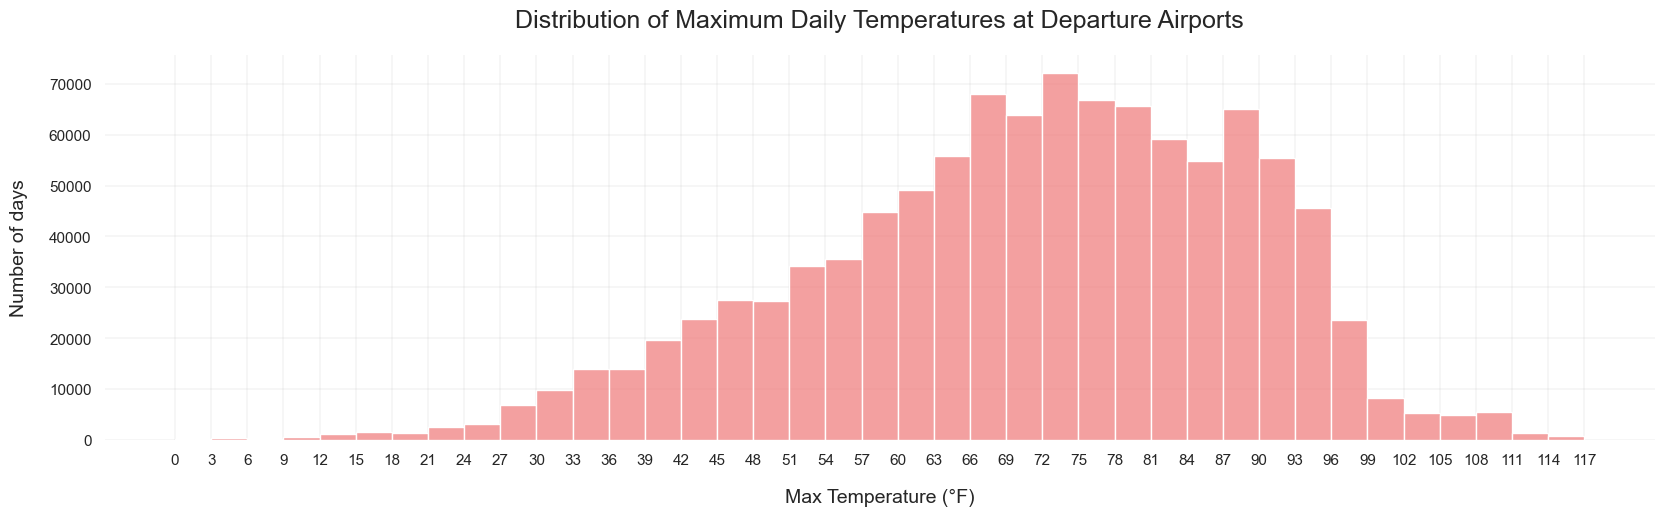

In [49]:
# Ustawiamy styl
sns.set(style="whitegrid")

# Dostosowujemy grubość linii siatki
sns.set_context(rc={"grid.linewidth": 0.25, "axes.linewidth": 0})

# Tworzymy biny od 0 do maksymalnej wartości tmax, co 3 stopnie
bins = np.arange(0, flight_df['tmax'].max() + 5, 3)

# Tworzymy histogram z Seaborn
plt.figure(figsize=(20, 5))
sns.histplot(flight_df['tmax'], bins=bins, kde=False, color='lightcoral')

# Dodajemy tytuł i etykiety osi
plt.title('Distribution of Maximum Daily Temperatures at Departure Airports', fontsize=18, pad=20)
plt.xlabel('Max Temperature (°F)', fontsize=14, labelpad=15)
plt.ylabel('Number of days', fontsize=14, labelpad=15)

# Ustawiamy oś x z krokiem co 10 binów
plt.xticks(bins)

# Wyświetlamy wykres
plt.show()

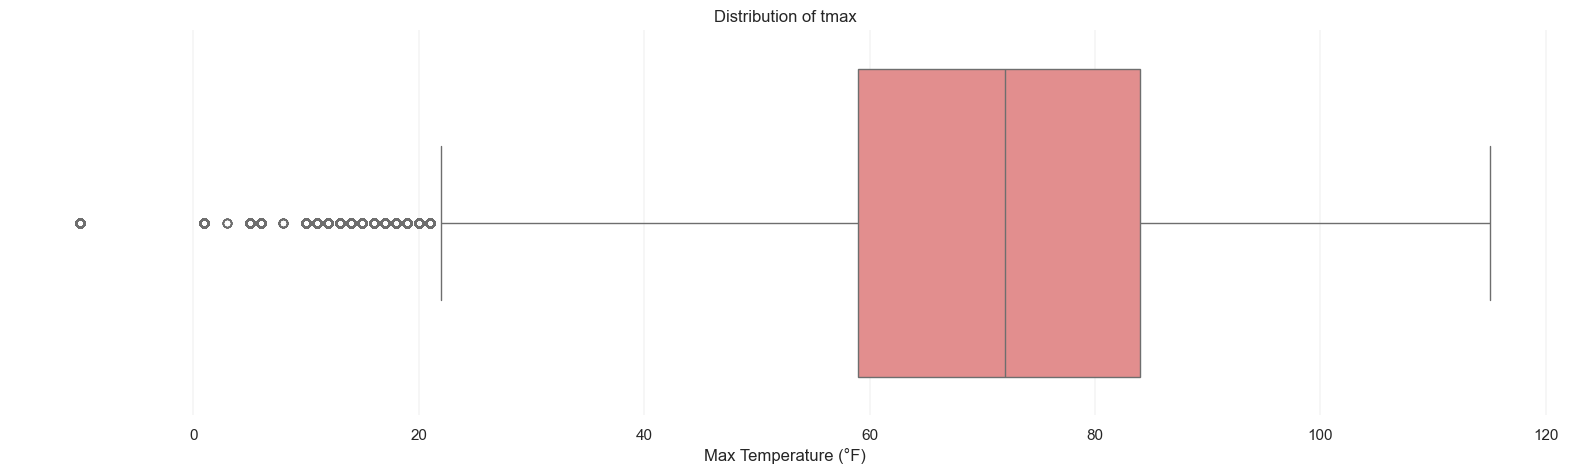

In [50]:
# Rysujemy wykres pudełkowy dla zmiennej tmax
plt.figure(figsize=(20, 5))
sns.boxplot(x=flight_df['tmax'], color='lightcoral')
plt.title('Distribution of tmax')
plt.xlabel('Max Temperature (°F)')
plt.show()

In [51]:
# Tworzymy kolumnę z przedziałami temperatur
flight_df['tmax_group'] = pd.cut(flight_df['tmax'], bins=range(int(flight_df['tmax'].min()) - 5, int(flight_df['tmax'].max()) + 5, 5))

In [52]:
# Grupujemy dane po tmax_group i obliczamy odsetek opóźnień
tmax_delay_df = flight_df.groupby('tmax_group', observed=True).agg(
    total_flights=('is_delayed', 'count'),
    delayed_flights=('is_delayed', 'sum')
)

tmax_delay_df['delay_percentage'] = ((tmax_delay_df['delayed_flights'] / tmax_delay_df['total_flights']) * 100).round(2)

In [53]:
tmax_delay_df

,total_flights,delayed_flights,delay_percentage
tmax_group,,,
"(-15, -10]",125,84,67.20
"(0, 5]",468,219,46.79
"(5, 10]",549,205,37.34
"(10, 15]",1915,537,28.04
"(15, 20]",2530,901,35.61
"(20, 25]",4863,1333,27.41
"(25, 30]",10580,2591,24.49
"(30, 35]",21064,5400,25.64
"(35, 40]",26421,6057,22.92


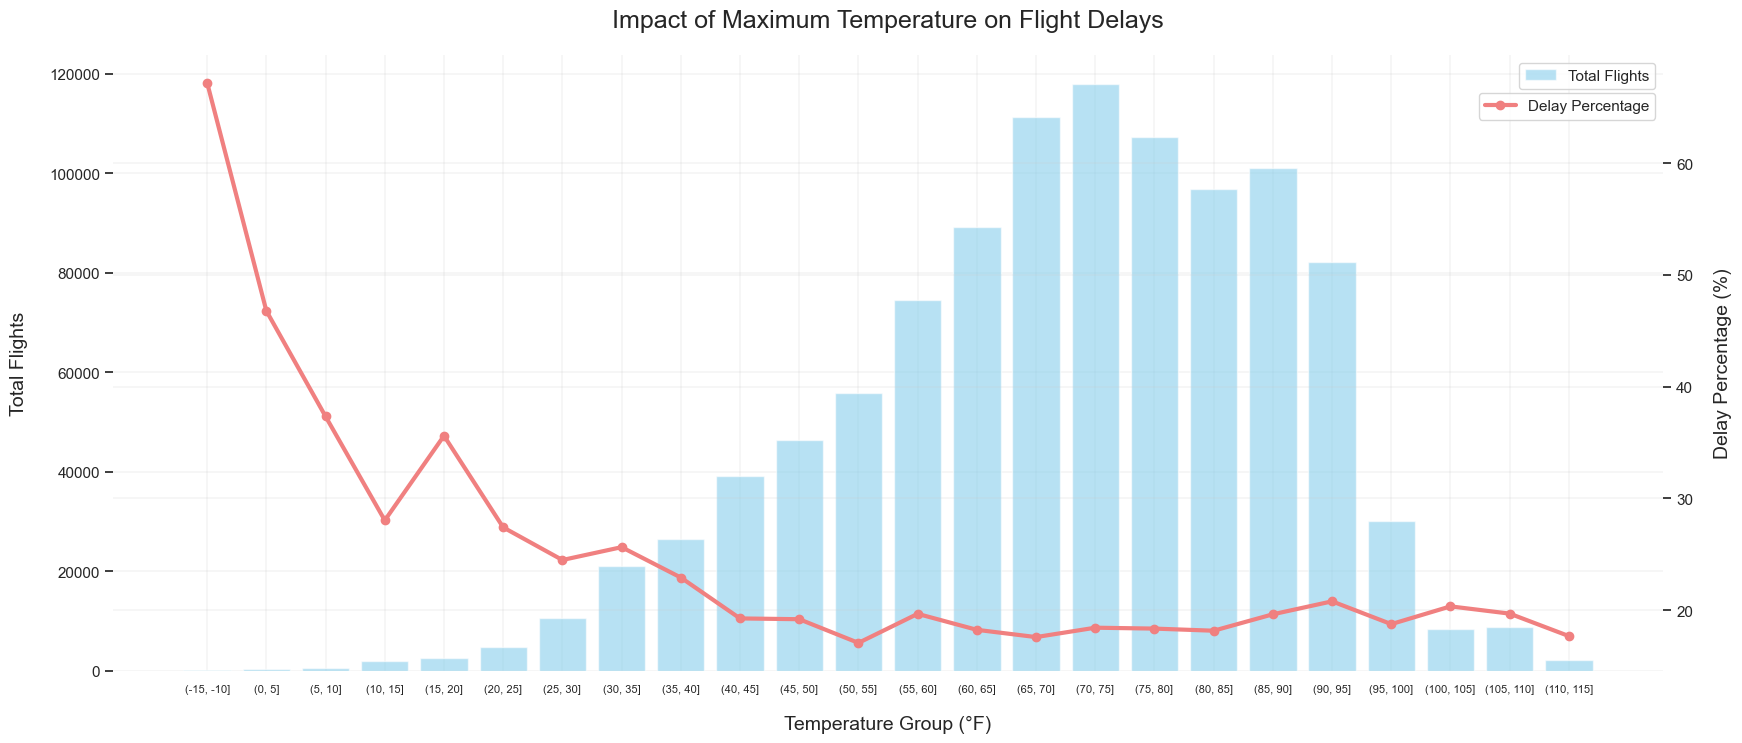

In [54]:
# Ustawiamy styl
sns.set(style="whitegrid")

# Dostosowujemy grubość linii siatki
sns.set_context(rc={"grid.linewidth": 0.25, "axes.linewidth": 0})

# Tworzymy figure i osie
fig, ax1 = plt.subplots(figsize=(20, 8))

# Rysujemy wykres słupkowego dla całkowitej liczby lotów
ax1.bar(tmax_delay_df.index.astype(str), tmax_delay_df['total_flights'], color='skyblue', alpha=0.6, label='Total Flights')

# Tworzymy drugą oś dla procentu opóźnień
ax2 = ax1.twinx()
ax2.plot(tmax_delay_df.index.astype(str), tmax_delay_df['delay_percentage'], color='lightcoral', marker='o', linewidth=3, label='Delay Percentage')

# Dodajemy tytuły
ax1.set_title('Impact of Maximum Temperature on Flight Delays', fontsize=18, pad=20)
ax1.set_xlabel('Temperature Group (°F)', fontsize=14, labelpad=15)
ax1.set_ylabel('Total Flights', fontsize=14, labelpad=15)
ax2.set_ylabel('Delay Percentage (%)', fontsize=14, labelpad=15)

# Dodajemy legendę
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.95), ncol=1)

# Zmniejszenie rozmiaru czcionki etykiet osi X
ax1.tick_params(axis='x', labelsize=8)

# Wyświetlamy wykres
plt.show()

KOMENTARZ: Temperatury poniżej punktu zamarzania wody (32°F) są związane z wysokim odsetkiem opóźnień lotów. W przedziale od -15°F do -10°F, odsetek opóźnień wynosi aż 67.20%. Nawet w przedziale od 0°F do 15°F opóźnienia utrzymują się na poziomie 28-47%. Przyczyną mogą być trudne warunki zimowe, takie jak oblodzenie, opady śniegu, oraz konieczność odladzania samolotów, co wydłuża czas przygotowania do lotu. W pozostałych zakresach temperatur nie zaobserwowano wyraźnej zależności między temperaturą a odsetkiem opóźnień, co sugeruje, że inne czynniki mogą mieć większy wpływ na punktualność lotów w umiarkowanych i wyższych temperaturach.

# Podsumowanie
W tej części warsztatu dokonaliśmy kompleksowej analizy posiadanego zbioru danych. Eksploracja
pozwoliła nam na zapoznanie się z cechami charakterystycznymi lotów - wiemy już, które 
zmienne mogą mieć wpływ na opóźnienia lotów, a które nie. Co warto podkreślić, skupiliśmy się na wielu
aspektach tej analizy, co otwiera potencjalnie również inne możliwości dalszej pracy nad tą bazą.

In [57]:
# Ścieżka do zapisu pliku CSV
file_path = '../data/processed/flight_df_03.csv'

# Zapisujemy ramkę danych do pliku CSV
flight_df.to_csv(file_path, index=False)